In [1]:
import os
import numpy as np
import imageio.v3 as iio
from skimage.io import imread
import cv2
import matplotlib.pyplot as plt
import random
from skimage.transform import resize
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
!unzip /content/drive/MyDrive/DS102/BTTH3/yalefaces.zip

Archive:  /content/drive/MyDrive/DS102/BTTH3/yalefaces.zip
   creating: yalefaces/
   creating: yalefaces/person-4/
  inflating: yalefaces/person-4/rightlight  
  inflating: yalefaces/person-4/leftlight  
  inflating: yalefaces/person-4/normal  
  inflating: yalefaces/person-4/noglasses  
  inflating: yalefaces/person-4/happy  
  inflating: yalefaces/person-4/centerlight  
  inflating: yalefaces/person-4/sleepy  
  inflating: yalefaces/person-4/glasses  
  inflating: yalefaces/person-4/wink  
  inflating: yalefaces/person-4/surprised  
   creating: yalefaces/person-15/
  inflating: yalefaces/person-15/rightlight  
  inflating: yalefaces/person-15/leftlight  
  inflating: yalefaces/person-15/normal  
  inflating: yalefaces/person-15/noglasses  
  inflating: yalefaces/person-15/sad  
  inflating: yalefaces/person-15/centerlight  
  inflating: yalefaces/person-15/sleepy  
  inflating: yalefaces/person-15/glasses  
  inflating: yalefaces/person-15/wink  
  inflating: yalefaces/person-15/su

In [4]:
BASE_DIR = "yalefaces"
folders = [
    "person-1",
    "person-2",
    "person-4",
    "person-5",
    "person-7",
    "person-8",
    "person-10",
    "person-11",
    "person-12",
    "person-13",
    "person-14",
    "person-15"
]

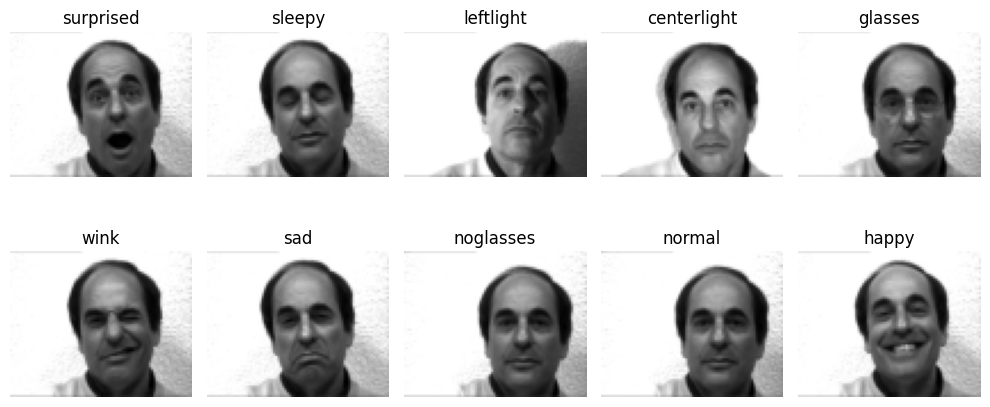

In [5]:
person_folder = random.choice(folders)
plt.figure(figsize=(10, 5))  # width, height in inches

for i, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
    try:
        image = imread(os.path.join(BASE_DIR, person_folder, filename))
        image = image.squeeze(0)
        image = resize(image, (64, 80), anti_aliasing=True)

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(filename)

    except Exception as e:
        print(f"Lỗi khi xử lý file {filename}: {e}")

plt.tight_layout()
plt.show()

In [6]:
data = {}
for person_folder in folders:
  for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    if person_folder not in data:
      data[person_folder] = [image]
    else:
      data[person_folder].append(image)

for person in data:
  data[person] = np.concat(data[person], axis = 0).reshape(10, -1)

In [7]:
data['person-1'].shape

(10, 5120)

# Standardizing images

In [8]:
def standardizing(images):
  images_mean = images.mean()
  images_std = images.std()
  images = (images - images_mean) / images_std
  images = images.astype(np.float32)
  return images

# Assignment 1 (4 scores): Implement PCA using Numpy.

In [9]:
class PrincipalComponentAnalysis:
  def __init__(self, d_principle: int = 1):
    self.d_principle = d_principle

  def fit(self, X):
    cov = (X.T @ X)

    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
    signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
    eigenvectors = eigenvectors * signs[np.newaxis,:]
    eigenvectors = eigenvectors.T

    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i,:]) for i in range(len(eigenvalues))]

    eigen_pairs.sort(key = lambda pair: pair[0], reverse = True)

    eigenvalues = np.array([value for (value,_) in eigen_pairs])
    eigenvectors = np.array([vector for (_,vector) in eigen_pairs])

    self.principle_values = eigenvalues[:self.d_principle]
    self._W = eigenvectors[:self.d_principle]

  def transform(self, X):
    X_hat = self._W @ X
    return X_hat

# Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

In [10]:
PCA = PrincipalComponentAnalysis(d_principle=20)

In [11]:
images = []
for person in data:
  images.append(data[person])
images = np.concat(images, axis = 0)
images = standardizing(images)
images.shape

(120, 5120)

In [12]:
PCA.fit(images)

In [13]:
PCA._W.shape

(20, 5120)

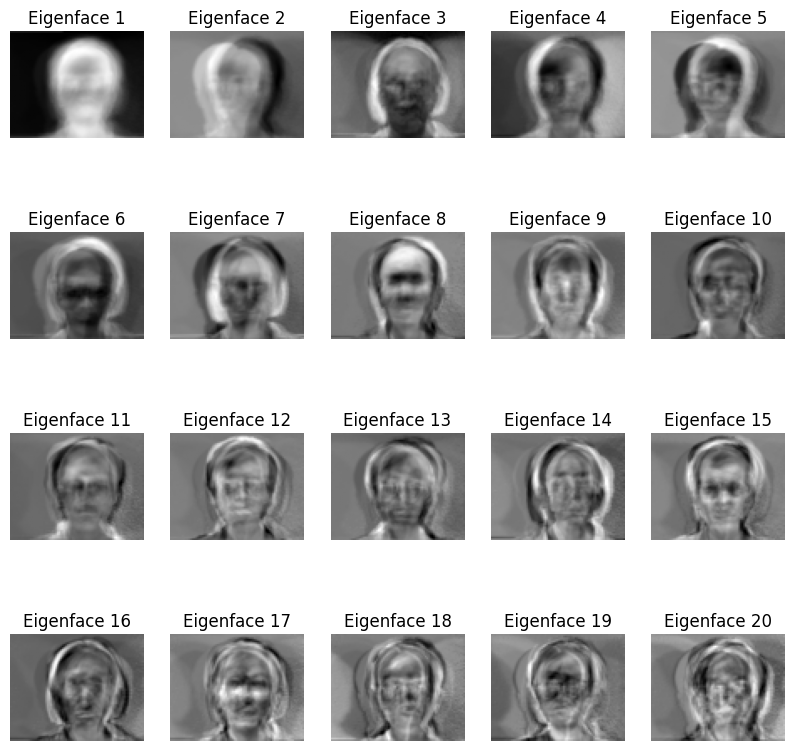

In [14]:
eigenfaces = PCA._W
eigenfaces = eigenfaces.reshape(20, 64, 80)
plt.figure(figsize=(10,10))
for ith, eigenface in enumerate(eigenfaces):
  plt.subplot(4,5,ith+1)
  plt.imshow(eigenface, cmap='gray')
  plt.axis('off')
  plt.title(f'Eigenface {ith+1}')
plt.show()

In [15]:
mean_faces = {
    person: np.mean(data[person], axis=0) for person in data
}

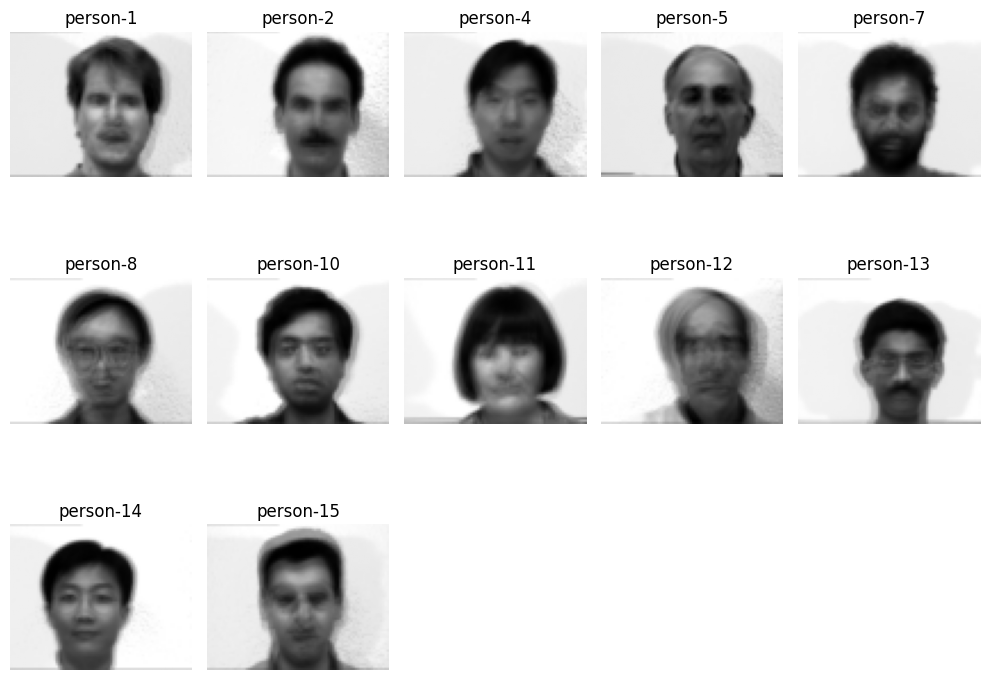

In [16]:
plt.figure(figsize=(10,10))
for ith, person in enumerate(mean_faces):
  mean_face = mean_faces[person]
  mean_face = mean_face.reshape(64, 80)
  plt.subplot(4,5,ith+1)
  plt.imshow(mean_face, cmap='gray')
  plt.axis('off')
  plt.title(person)

plt.tight_layout()
plt.show()

In [17]:
projected_mean_faces = {}
for person in mean_faces:
  mean_face = mean_faces[person]
  projected_mean_faces[person] = PCA.transform(mean_face)

# Assignment 3 (2 scores):
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

In [18]:
labels = []
test_images = []
TEST_DIR = "yalefaces/test"
for filename in os.listdir(os.path.join(TEST_DIR)):
  person_name = filename.split(".")[0]
  labels.append(person_name)
  image = imread(os.path.join(TEST_DIR, filename))
  image = resize(image, (1,64, 80), anti_aliasing=True)
  test_images.append(image)

test_images = np.concat(test_images, axis = 0)
test_images.shape

(15, 64, 80)

In [19]:
labels

['person-13',
 'person-6',
 'person-5',
 'person-1',
 'person-10',
 'person-2',
 'person-12',
 'person-4',
 'person-9',
 'person-3',
 'person-8',
 'person-7',
 'person-14',
 'person-15',
 'person-11']

In [20]:
def Euclide_distance(X, Y):
  assert X.shape == Y.shape
  return (((X-Y)**2).sum())**0.5

In [21]:
predictions = {}
for label, image in zip(labels, test_images):
  image = image.reshape(-1)
  projected_face = PCA.transform(image)
  closest_distance = np.inf
  closest_person = None
  for person in projected_mean_faces:
    mean_face = projected_mean_faces[person]
    distance = Euclide_distance(mean_face, projected_face)
    if distance < closest_distance:
      closest_distance = distance
      closest_person = person
  predictions[label] = closest_person

In [22]:
EMs = []
for label in predictions:
  EMs.append(label == predictions[label])

In [23]:
print(f"Accuracy: {np.mean(EMs)*100:.2f}%")

Accuracy: 53.33%
